# Import libraries

In [1]:
import os
import sys
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.metadata.SignalMetadata import SignalMetadata
from lhcsmapi.pyedsl.dbsignal.post_mortem.PmDbRequest import PmDbRequest

In [2]:
# External libraries
print('Loading (1/12)'); import sys, warnings
print('Loading (2/12)'); from IPython.display import display, Javascript, HTML, clear_output
print('Loading (3/12)'); import pandas as pd

# Internal libraries
print('Loading (4/12)'); import lhcsmapi
print('Loading (5/12)'); from lhcsmapi.Time import Time
print('Loading (6/12)'); from lhcsmapi.Timer import Timer
print('Loading (7/12)'); from lhcsmapi.analysis.RbCircuitQuery import RbCircuitQuery
print('Loading (8/12)'); from lhcsmapi.analysis.RbCircuitAnalysis import RbCircuitAnalysis
print('Loading (9/12)'); from lhcsmapi.analysis.report_template import apply_report_template
print('Loading (10/12)'); from lhcsmapi.analysis.expert_input import get_expert_decision
print('Loading (11/12)'); from lhcsmapi.gui.DateTimeBaseModule import DateTimeBaseModule
print('Loading (12/12)'); from lhcsmapi.gui.pc.FgcPmSearchModuleMediator import FgcPmSearchModuleMediator

clear_output()
lhcsmapi.get_lhcsmapi_version()
lhcsmapi.get_lhcsmhwc_version('../__init__.py')

Analysis executed with lhc-sm-api version: 1.5.18
Analysis executed with lhc-sm-hwc notebooks version: unknown


In [3]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable


# Read the (clean) MP3 file

In [4]:
mp3_fpa_df_raw = pd.read_excel("./RB_TC_extract_2021_11_22.xlsx")
len(mp3_fpa_df_raw)

4409

In [5]:
# First row contains units, 9 rows contain only "Before Notebooks" and "After Notebooks" information, which need to be droped
mp3_fpa_df = mp3_fpa_df_raw.dropna(subset = ['Date (FGC)', 'Circuit Name'])
mp3_fpa_df_raw.iloc[~mp3_fpa_df_raw.index.isin(mp3_fpa_df.index)] #show droped rows

,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),Delta_t(EE_even-PIC),Delta_t(EE_odd-PIC),...,Outer cable type,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47
0,NaN,RB,NaN,2008-04-01 00:00:00,13:14:15,NaN,NaN,[ms],[ms],[ms],...,NaN,[A],[A],[A],NaN,NaN,NaN,NaN,NaN,NaN
1,RB.A12,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
169,RB.A23,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
264,RB.A34,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
545,RB.A45,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
897,RB.A56,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1146,RB.A67,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1268,RB.A78,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1430,RB.A81,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1581,NaN,RB,After Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,After Notebooks,NaN,NaN,NaN


# Find FGC timestamp for each FPA event in MP3 excel

In [6]:
def find_real_fgc_timestamp(circuit_name, fgc_datetime):
    
    fgc_timestamp = Time.to_unix_timestamp(fgc_datetime)
    metadata_fgc = SignalMetadata.get_circuit_signal_database_metadata(
            'RB', circuit_name, 'PC', 'PM', timestamp_query=fgc_timestamp)

    one_sec_in_ns = 1e9 
    start_time = fgc_timestamp - one_sec_in_ns
    end_time = fgc_timestamp + one_sec_in_ns
 
    source_timestamp_fgc = PmDbRequest.find_events(metadata_fgc['source'],
                                                   metadata_fgc['system'],
                                                   metadata_fgc['className'],
                                                   t_start=start_time,
                                                   t_end=end_time)

    return [(circuit_name, el[1]) for el in source_timestamp_fgc]

# getting the list of timestamps
def get_fgc_timestamp(d):
    date_time_str = f"{d['Date (FGC)']} {d['Time (FGC)']}".replace("00:00:00 ","")
    real_fgc_timestamps = find_real_fgc_timestamp(d['Circuit Name'], date_time_str)
    if len(real_fgc_timestamps) > 1:
        print(f"Found more than one event for timestamp {date_time_str}")
    elif not real_fgc_timestamps:
        print(f"Found no event for timestamp {date_time_str}")
        return None
    _, real_fgc_timestamp = real_fgc_timestamps[0]
    return int(real_fgc_timestamp)

In [7]:
mp3_fpa_df['timestamp_fgc'] = mp3_fpa_df.apply(get_fgc_timestamp, axis=1)

Found no event for timestamp 2008-08-19 12:13:28
Found no event for timestamp 2008-08-19 18:53:12
Found no event for timestamp 2008-08-19 20:15:07
Found no event for timestamp 2008-08-19 20:15:07
Found no event for timestamp 2008-08-20 18:41:36
Found no event for timestamp 2008-08-22 09:59:25
Found no event for timestamp 2008-08-22 09:59:25
Found no event for timestamp 2008-08-22 09:59:25
Found no event for timestamp 2008-07-08 08:30:10
Found no event for timestamp 2008-07-08 14:39:16
Found no event for timestamp 2008-07-09 17:14:45
Found no event for timestamp 2008-07-11 14:42:00
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-08-09 02:19:48
Found no event for timestamp 2008-09-07 17:34:03
Found no event for timestamp 2009-12-04 11:19:48
Found no event for t

Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-09 15:13:38
Found no event for timestamp 2008-05-09 15:13:38
Found no event for timestamp 2008-05-09 15:13:38
Found no event for timestamp 2008-05-09 15:13:38
Found no event for t

Found no event for timestamp 2008-06-30 11:40:04
Found no event for timestamp 2008-06-30 15:39:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:58:40.300000
Found no event for timestamp 2021-05-22 00:58:40.300000
Found no event for timestamp 2021-05-22 00:58:40.300000
Found no event for timestamp 2021-05-22 00:58:40.300000
Found no event for timestamp 2021-05-22 00:58:40


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Filter mp3 file

In [8]:
# dropping duplicates of timestamps
print(f"{len(mp3_fpa_df['timestamp_fgc'])} mp3 excel file entries")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name']) ### you need timestamp + circuit !!! 

print(f"{len(mp3_fpa_df_unique)} unique fgc events") # 841 Primary quenches?
print(f"{len(mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1])} mp3 primary quench entries") # 834 primary quenches with correct notes

4399 mp3 excel file entries
841 unique fgc events
918 mp3 primary quench entries


In [9]:
operation_periods =[
    'HWC 2007', 
    'HWC 2008', 
    'HWC 2009',
    'HWC 2010', 
    'HWC Oct 2014', 
    'HWC Dec 2014', 
    'HWC 2015', 
    'Operation 2015', 
    'HWC 2016',
    'Operation 2016',
    'HWC Dec 2016', 
    'HWC 2017', 
    'Operation 2017', 
    'Operation 2018',
    'HWC Dec 2018',
    'HWC 2021', 
]

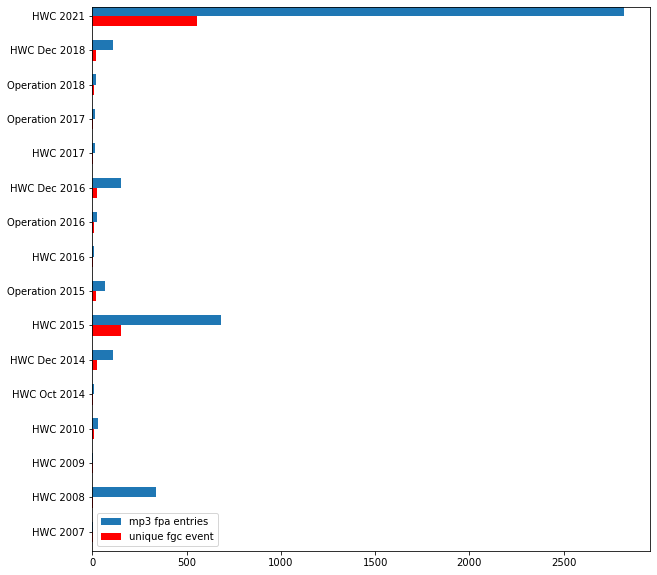

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
width=0.3
mp3_fpa_df.Period.value_counts()[operation_periods].plot(ax=ax, kind='barh', width=width, position=0, label='mp3 fpa entries')
mp3_fpa_df_unique.Period.value_counts()[operation_periods].plot(ax=ax, kind='barh', width=width, position=1, color='red', label='unique fgc event')
#mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1].Period.value_counts()[operation_periods].plot(ax=ax, kind='barh', width=width, position=2, color='orange', label='unique fgc event')
plt.legend()

In [11]:
# mp3 primary quench entries with no unique fgc entry
mp3_fpa_df_missing = mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1][~mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1].index.isin(mp3_fpa_df_unique.index)] 
mp3_fpa_df_missing.Period.value_counts()

HWC 2008          69
HWC 2007           4
HWC 2021           4
HWC 2010           2
HWC 2015           2
HWC 2009           1
Operation 2017     1
HWC Dec 2018       1
Name: Period, dtype: int64

In [12]:
mp3_fpa_df_missing[mp3_fpa_df_missing['Period'] == 'HWC 2021']

,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),Delta_t(EE_even-PIC),Delta_t(EE_odd-PIC),...,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47,timestamp_fgc
3050,RB.A12,RB,HWC 2021,2021-05-22 00:00:00,00:43:20.100000,Magnet quench,2021-05-22 00:43:20,31,592,96,...,11313,550,NaN,NaN,emm,1.5.13,1.5.63,NaN,NaN,NaN
3056,RB.A23,RB,HWC 2021,2021-05-22 00:00:00,00:58:40.300000,Magnet quench,2021-05-22 00:58:40,27,594,91,...,11213,261,NaN,NaN,emm,1.5.13,1.5.63,NaN,NaN,NaN
3529,RB.A56,RB,HWC 2021,2021-06-15 00:00:00,00:10:53.600000,Magnet quench,00:10:53.500000,20,596,96,...,12394,-1050,NaN,NaN,emm,1.5.14,1.5.64,NaN,NaN,NaN
3569,RB.A56,RB,HWC 2021,2021-06-19 00:00:00,00:25:03.400000,Magnet quench,00:25:03.400000,31,596,95,...,12307,-890,NaN,NaN,hagen,1.5.14,1.5.64,NaN,NaN,NaN


# Select events to download

In [31]:
# Time.to_string(1514761200000000000), Time.to_unix_timestamp('2018-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= 1388530800000000000].reset_index(drop=True) ### we want to analyse >= 2017.01.01
len(mp3_fpa_df_period)

824

In [36]:
from abc import ABC, abstractmethod
import numpy as np

class DataAcquisition(ABC):
    """
    abstract class which acts as a template to download LHC cicuit data
    """
    def __init__(self,
                 circuit_type: str,
                 circuit_name: str,
                 timestamp_fgc: int
                 ):
        """
        Specifies data to query from
        """
        self.circuit_type = circuit_type
        self.circuit_name = circuit_name
        self.timestamp_fgc = timestamp_fgc

    def get_signal_timestamp(self) -> int:
        """
        abstract method to find correct timestamp for selected signal, default is fgc timestamp
        """
        return self.timestamp_fgc

    @abstractmethod
    def get_signal_data(self) -> list:
        """
        abstract method to get selected signal
        """
        
    @abstractmethod
    def get_reference_signal_data(self) -> list:
        """
        abstract method to get selected signal
        """

In [45]:
class PC_PM(DataAcquisition):
    """
    Subclass of DataAquistion to query PC_PM
    """
    def __init__(self, 
                 circuit_type: str,
                 circuit_name: str,
                 timestamp_fgc: int
                 ):
        
        super(PC_PM, self).__init__(circuit_type, circuit_name, timestamp_fgc)
        self.signal_names = ['I_MEAS', 'I_A', 'I_EARTH', 'I_EARTH_PCNT', 'I_REF']
        self.query_builder = RbCircuitQuery(self.circuit_type, self.circuit_name) 
        self.signal_timestamp = self.get_signal_timestamp()
    
    def get_signal_data(self) -> list:
        """
        abstract method to get selected signal
        """      
        return self.query_builder.query_pc_pm(self.signal_timestamp, self.signal_timestamp, signal_names=self.signal_names)
    
    def get_reference_signal_data(self) -> list:
        """
        abstract method to get selected signal
        """
        timestamp_fgc_ref = rb_query.get_fgc_timestamp_ref(timestamp_fgc)
        return self.query_builder.query_pc_pm(timestamp_fgc_ref, timestamp_fgc_ref, signal_names=self.signal_names)

In [46]:
circuit_type = mp3_fpa_df_unique['Circuit Family'].iloc[-1]
circuit_name = mp3_fpa_df_unique['Circuit Name'].iloc[-1]
timestamp_fgc = mp3_fpa_df_unique['timestamp_fgc'].iloc[-1]
acquire_data(PC_PM)

	Querying PM event signal(s) STATUS.I_REF, IEARTH.I_EARTH, STATUS.I_MEAS, STATUS.I_EARTH_PCNT, IAB.I_A for system: RPTE.UA83.RB.A78, className: lhc_self_pmd, source: FGC at 2021-11-15 19:55:49.840


[         STATUS.I_MEAS
 -60.02     11600.00000
 -60.00     11599.99800
 -59.98     11599.99600
 -59.96     11599.99600
 -59.94     11599.99700
 ...                ...
  359.88      209.17440
  359.90      209.12437
  359.92      209.07140
  359.94      209.02072
  359.96      208.96970
 
 [21000 rows x 1 columns],              IAB.I_A
 -4.104000  11600.043
 -4.103001  11600.045
 -4.102001  11600.042
 -4.101000  11600.062
 -4.100000  11600.066
 ...              ...
  4.083000  11181.244
  4.084000  11181.137
  4.084999  11181.008
  4.086000  11180.900
  4.087000  11180.813
 
 [8192 rows x 1 columns],         IEARTH.I_EARTH
 -10.24       -0.000929
 -10.22       -0.000929
 -10.20       -0.000929
 -10.18       -0.000876
 -10.16       -0.000876
 ...                ...
  10.14        0.015657
  10.16        0.015657
  10.18        0.015657
  10.20        0.015657
  10.22        0.015657
 
 [1024 rows x 1 columns],          STATUS.I_EARTH_PCNT
 -60.02                 -1.81
 -60.00           

'RB.A78'

In [17]:
mp3_fpa_df_unique

,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),Delta_t(EE_even-PIC),Delta_t(EE_odd-PIC),...,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47,timestamp_fgc
2,RB.A12,RB,HWC 2008,2008-08-19 00:00:00,12:13:28,Heater-provoked,NaN,NaN,NaN,NaN,...,11365,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,RB.A12,RB,HWC 2009,2009-12-05 00:00:00,19:30:26,Heater-provoked,NaN,NaN,NaN,NaN,...,11631,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.260038e+18
11,RB.A12,RB,HWC 2010,2010-02-04 00:00:00,14:06:55,QPS trip,NaN,NaN,NaN,NaN,...,12284,-,NaN,Q during ramp down from 2 kA when opening the ...,NaN,NaN,NaN,NaN,NaN,1.265289e+18
12,RB.A12,RB,HWC 2010,2010-02-13 00:00:00,13:44:52,QPS trip,NaN,NaN,NaN,NaN,...,11369,-,NaN,Dump RR17 noisy (40 V pp),NaN,NaN,NaN,NaN,NaN,1.266065e+18
22,RB.A12,RB,HWC Dec 2014,2014-12-11 00:00:00,21:45:14,Heater-provoked,NaN,NaN,NaN,NaN,...,11573,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.418331e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,RB.A78,RB,HWC 2021,2021-11-12 00:00:00,19:00:12.620000,Magnet quench,2021-11-12 19:00:12.585000,35,592,93,...,12168,-588,NaN,NaN,hagen,1.5.18,1.5.66,NaN,NaN,1.636740e+18
4391,RB.A78,RB,HWC 2021,2021-11-13 00:00:00,13:31:01.040000,Magnet quench,2021-11-13 13:31:01.020000,20,589,93,...,12353,-759,NaN,NaN,hagen,1.5.18,1.5.66,NaN,NaN,1.636807e+18
4395,RB.A78,RB,HWC 2021,2021-11-14 00:00:00,08:40:06.280000,Magnet quench,2021-11-14 08:40:06.255000,25,589,93,...,11840,-247,13,Quenched at similar current 24 April (no memory!),hagen,1.5.18,1.5.66,NaN,NaN,1.636876e+18
4400,RB.A78,RB,HWC 2021,2021-11-15 00:00:00,07:08:34.140000,Magnet quench,2021-11-15 07:08:34.110000,30,590,91,...,12857,-1260,472,NaN,hagen,1.5.18,1.5.66,NaN,NaN,1.636957e+18


In [85]:
data_types = { 
    'pc_pm':{
        'query': rb_query.query_pc_pm
        'timestamp': timestamp_fgc,
        'reference_timestamp': rb_query.get_fgc_timestamp_ref(timestamp_fgc),
        'signals': ['I_MEAS', 'I_A', 'I_EARTH', 'I_EARTH_PCNT', 'I_REF']
    },
    'ee_u_dump_res_pm':{
        'query': rb_query.query_ee_u_dump_res_pm,
        'timestamp': rb_query.find_source_timestamp_ee(timestamp_fgc),
        'system': ['EE_ODD', 'EE_EVEN'],
        'signals': ['U_DUMP_RES']
    }
    'ee_t_res_pm':{
        'query': rb_query.query_ee_t_res_pm,
        'timestamp': rb_query.find_source_timestamp_ee(timestamp_fgc),
        'system': ['EE_ODD', 'EE_EVEN'],
        'signals': ['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3']
    }
    'ee_nxcals':{
        'query': rb_query.query_ee_nxcals,
        'timestamp': timestamp_fgc,
        'system': ['EE_ODD', 'EE_EVEN'],
        'signals': ['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3','ST_RES_OVERTEMP']
        'spark': spark
    }
    'voltage_nxcals':{
        'query': rb_query.query_voltage_nxcals,
        'timestamp': timestamp_fgc,
        'signals': ['DIODE_RB', 'U_DIODE_RB'],
        'duration': [(50, 's'), (350, 's')]
    }
    'voltage_logic_iqps':{
        'query': rb_query.query_voltage_logic_iqps,
        'timestamp': rb_query.find_source_timestamp_qds(timestamp_fgc),
        'signals': ['U_QS0', 'U_1', 'U_2', 'ST_NQD0', 'ST_MAGNET_OK']
    }
    'voltage_nqps':{
        'query': rb_query.query_voltage_nqps,
        'timestamp': rb_query.find_source_timestamp_nqps(timestamp_fgc),
    }
    'qh_pm':{
        'query': rb_query.query_qh_pm,
        'timestamp': rb_query.find_source_timestamp_qh(timestamp_fgc),
        'signal_names': ['I_HDS', 'U_HDS'],
        'is_ref': [False, True]
    }
    'current_voltage_diode_leads_pm':{
        'query': rb_query.query_current_voltage_diode_leads_pm,
        'timestamp': timestamp_fgc
    }
    'current_voltage_diode_leads_nxcals':{
        'query': rb_query.query_current_voltage_diode_leads_nxcals,
        'timestamp': timestamp_fgc,
        'duration': [(50, 's'), (350, 's')]
    }
    'voltage_nxcal':{
        'query': rb_query.query_voltage_nxcals,
        'signals': ['VF', 'U_EARTH_RB'],
        'timestamp': timestamp_fgc,
        'duration': [(50, 's'), (350, 's')]
    }
    'leads':{
        'query': rb_query.query_leads,
        'signals': ['VF', 'U_EARTH_RB'],
        'system': ['LEADS_ODD','LEADS_EVEN']
        'signals': ['U_RES','U_HTS']
        'timestamp': rb_query.find_timestamp_leads(timestamp_fgc),
        'spark': spark
    }
            
}

In [87]:
data_types['pc_pm']['class']()

'asd'

In [72]:
def analyse_on_event(d):
    circuit_type='RB'    
    timestamp_fgc = int(d['timestamp_fgc'])
    circuit_name = d['Circuit Name']
    author = 'cobermair'
    is_automatic = False

    target_dir = "../data/rb_fpa_data_raw/"
    os.makedirs(target_dir, exist_ok = True)
    
    for signal in 
    
    
    filename = target_dir+f"quench_{timestamp_fgc}_{circuit_name}.p.gz"
    
    if os.path.isfile(filename):
        filesize = os.stat(filename).st_size
        if filesize > 1024*1024*20: # 1024 * 1024 = 1 MB
            print(f"WARNING: file {filename} already exists with size {filesize}, no analysis needed")
            return True
        else:
            print(f"WARNING: file {filename} already exists with size {filesize}, analysis needed")
    else:
        print(f"WARNING: file {filename} does not already exists, analysis needed")
        
    rb_query = RbCircuitQuery(circuit_type,
                              circuit_name, 
                              max_executions=45)    

    print(f"Starting analysis for the {filename}")

    loc = 0
    
    try:
    
        # search in a windows of 1h?        
        # ???
                
        loc+=1
          
        print(timestamp_fgc)
        # TODO: change the call !
        #timestamp_pic = query_all_fgc_pm_events(timestamp_fgc, duration=[(1, 's'),(1, 's')]).iloc[0].values
        #print(type(timestamp_pic),timestamp_pic)
        timestamp_pic = rb_query.find_timestamp_pic(timestamp_fgc, spark=spark)
        print(type(timestamp_pic),timestamp_pic)
        
        loc+=1
        
        ######
        # PC #
        ######

        # PC Current
        try:
            i_meas_df, i_a_df, i_earth_df, i_earth_pcnt_df, i_ref_df = rb_query.query_pc_pm(
                timestamp_fgc, 
                timestamp_fgc, 
                signal_names=['I_MEAS', 'I_A', 'I_EARTH', 'I_EARTH_PCNT', 'I_REF'])
        except:
            i_meas_df=None
            i_a_df=None
            i_earth_df=None
            i_earth_pcnt_df=None
            i_ref_df=None
        loc+=1

        timestamp_fgc_ref = rb_query.get_fgc_timestamp_ref(timestamp_fgc) ### you don't need ref (it stands for a reference event)
        loc+=1

        try:
            i_meas_ref_df, i_earth_ref_df, i_earth_pcnt_ref_df = rb_query.query_pc_pm(
                timestamp_fgc_ref, 
                timestamp_fgc_ref, 
                signal_names=['I_MEAS', 'I_EARTH', 'I_EARTH_PCNT'])          
        except:
            i_meas_ref_df=None
            i_earth_ref_df=None
            i_earth_pcnt_ref_df=None 
        loc+=1

        ######
        # EE #
        ######
        
        try:
        
            # EE Voltage ODD
            source_timestamp_ee_odd_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc, 
                system='EE_ODD')
            timestamp_ee_odd = source_timestamp_ee_odd_df.loc[0, 'timestamp']
            source_ee_odd = source_timestamp_ee_odd_df.loc[0, 'source']
            u_dump_res_odd_df = rb_query.query_ee_u_dump_res_pm(
                timestamp_ee_odd, 
                timestamp_fgc, 
                system='EE_ODD', 
                signal_names=['U_DUMP_RES'])[0]
            
            # EE TEMPERATURE ODD
            t_res_odd_0_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_odd_df.loc[0, 'timestamp'],
                timestamp_fgc, 
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                system='EE_ODD')

            if len(source_timestamp_ee_odd_df) > 1:
                t_res_odd_1_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_odd_df.loc[1, 'timestamp'], 
                    timestamp_fgc, 
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                    system='EE_ODD')
            else:
                t_res_odd_1_df = [pd.DataFrame(columns=['T_RES_BODY_1']),
                                  pd.DataFrame(columns=['T_RES_BODY_2']), 
                                  pd.DataFrame(columns=['T_RES_BODY_3'])]
                
            # EE TEMPERATURE REF ODD
            source_timestamp_ee_odd_ref_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc_ref,
                system='EE_ODD')
            t_res_odd_0_ref_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_odd_ref_df.loc[0, 'timestamp'],
                timestamp_fgc_ref, 
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                system='EE_ODD')
            if len(source_timestamp_ee_odd_ref_df) > 1:
                t_res_odd_1_ref_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_odd_ref_df.loc[1, 'timestamp'],
                    timestamp_fgc_ref, 
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    system='EE_ODD')
            else:
                t_res_odd_1_ref_df = [pd.DataFrame(columns=['T_RES_BODY_1']), 
                                      pd.DataFrame(columns=['T_RES_BODY_2']), 
                                      pd.DataFrame(columns=['T_RES_BODY_3'])]                
                            
        except: 
            
            source_timestamp_ee_odd_df = None
            timestamp_ee_odd = None
            source_ee_odd = None
            u_dump_res_odd_df = None
            t_res_odd_0_df = None
            t_res_odd_1_df = None
            source_timestamp_ee_odd_ref_df = None
            t_res_odd_0_ref_df = None
            t_res_odd_1_ref_df = None

        loc+=1
    
        try:
            
            # EE Voltage EVEN
            source_timestamp_ee_even_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc,
                system='EE_EVEN')
            timestamp_ee_even = source_timestamp_ee_even_df.loc[0, 'timestamp']
            source_ee_even = source_timestamp_ee_even_df.loc[0, 'source']
            u_dump_res_even_df = rb_query.query_ee_u_dump_res_pm(
                timestamp_ee_even, 
                timestamp_fgc,
                system='EE_EVEN',
                signal_names=['U_DUMP_RES'])[0]        
            
            # EE TEMPERATURE EVEN            
            t_res_even_0_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_even_df.loc[0, 'timestamp'],
                timestamp_fgc, 
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                system='EE_EVEN')
            if len(source_timestamp_ee_even_df) > 1:
                t_res_even_1_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_even_df.loc[1, 'timestamp'],
                    timestamp_fgc, 
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    system='EE_EVEN')
            else:
                t_res_even_1_df = [pd.DataFrame(columns=['T_RES_BODY_1']), 
                                   pd.DataFrame(columns=['T_RES_BODY_2']),
                                   pd.DataFrame(columns=['T_RES_BODY_3'])]
                
            # EE TEMPERATURE REF EVEN            
            source_timestamp_ee_even_ref_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc_ref, 
                system='EE_EVEN')            
            t_res_even_0_ref_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_even_ref_df.loc[0, 'timestamp'],
                timestamp_fgc_ref,
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                system='EE_EVEN')
            if len(source_timestamp_ee_even_ref_df) > 1:
                t_res_even_1_ref_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_even_ref_df.loc[1, 'timestamp'], 
                    timestamp_fgc_ref,
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    system='EE_EVEN')
            else:
                t_res_even_1_ref_df = [pd.DataFrame(columns=['T_RES_BODY_1']), 
                                       pd.DataFrame(columns=['T_RES_BODY_2']),
                                       pd.DataFrame(columns=['T_RES_BODY_3'])]
                
        except:
            
            source_timestamp_ee_even_df = None
            timestamp_ee_even = None
            source_ee_even = None
            u_dump_res_even_df = None
            t_res_even_0_df = None
            t_res_even_1_df = None
            source_timestamp_ee_even_ref_df = None
            t_res_even_0_ref_df = None
            t_res_even_1_ref_df = None
        loc+=1

        # EE after 3 hours
        unix_time_now = Time.to_unix_timestamp(Time.now())
        time_diff = (unix_time_now - timestamp_fgc)*1e-9

        try:
            
            if time_diff > 3 * 3600:
                t_res_body_long_dfs = \
                rb_query.query_ee_nxcals(
                    timestamp_fgc, 
                    system='EE_ODD',
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    spark=spark) \
                + rb_query.query_ee_nxcals(
                    timestamp_fgc, 
                    system='EE_EVEN',
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                    spark=spark)
                st_res_overtemp_long_dfs = \
                rb_query.query_ee_nxcals(
                    timestamp_fgc,
                    system='EE_ODD',
                    signal_names='ST_RES_OVERTEMP',
                    spark=spark,
                    t_thr=0) \
                + rb_query.query_ee_nxcals(
                    timestamp_fgc, 
                    system='EE_EVEN', 
                    signal_names='ST_RES_OVERTEMP',
                    spark=spark, 
                    t_thr=0)
            else:
                t_res_body_long_dfs = []
                st_res_overtemp_long_dfs = []
                print('Wait {} seconds to query EE temperature and status signals'.format(time_diff))            
        
        except:
            
            t_res_body_long_dfs = None
            st_res_overtemp_long_dfs = None
        loc+=1
            
        # U_DIODE - CALS
        try:
            u_diode_rb_dfs = rb_query.query_voltage_nxcals(
                'DIODE_RB', 
                'U_DIODE_RB', 
                timestamp_fgc, 
                spark=spark,
                duration=[(50, 's'), (350, 's')])
        except:
            u_diode_rb_dfs = None
        loc+=1

        # iQPS, nQPS - PM
        try:
            source_timestamp_qds_df = rb_query.find_source_timestamp_qds(timestamp_fgc)
        except: 
            source_timestamp_qds_df = None
        loc+=1
        try:
            source_timestamp_nqps_df = rb_query.find_source_timestamp_nqps(timestamp_fgc, 
                                                                           warn_on_missing_pm_buffers=True)
        except:
            source_timestamp_nqps_df = None
        loc+=1

        #if not source_timestamp_qds_df and not source_timestamp_nqps_df:
        #    results_table = rb_query.create_report_analysis_template(
        #        source_timestamp_qds_df,
        #        source_timestamp_nqps_df, 
        #        min(timestamp_pic),
        #        timestamp_fgc, 
        #        '../__init__.py', 
        #        i_meas_df, 
        #        author)
        #else:
        #    results_table = None

        # QDS
        try:
            u_qds_dfs = rb_query.query_voltage_logic_iqps(
                source_timestamp_qds_df, 
                signal_names=['U_QS0', 'U_1', 'U_2', 'ST_NQD0', 'ST_MAGNET_OK'])
            # QDS from second board (A/B)
            source_timestamp_qds_df['timestamp'] = source_timestamp_qds_df['timestamp'] + 2000000
            u_qds_dfs2 = rb_query.query_voltage_logic_iqps(
                source_timestamp_qds_df, 
                signal_names=['U_QS0', 'U_1', 'U_2', 'ST_NQD0', 'ST_MAGNET_OK'])
            source_timestamp_qds_df['timestamp'] = source_timestamp_qds_df['timestamp'] - 2000000
        except:
            u_qds_dfs = None
            u_qds_dfs2 = None
        loc+=1
            
        try:
            u_nqps_dfs = rb_query.query_voltage_nqps(
                source_timestamp_nqps_df, 
                source_timestamp_qds_df, 
                timestamp_fgc, 
                spark=spark)
        except:
            u_nqps_dfs = None
        loc+=1
            
        # QH 
        try:
            source_timestamp_qh_df = rb_query.find_source_timestamp_qh(
                timestamp_fgc, 
                duration=[(10, 's'), (500, 's')])
        except:
            source_timestamp_qh_df = None
        loc+=1
        try:
            i_hds_dfs = rb_query.query_qh_pm(
                source_timestamp_qh_df, 
                signal_names='I_HDS')
        except:
            i_hds_dfs = None
        loc+=1
        try:
            u_hds_dfs = rb_query.query_qh_pm(
                source_timestamp_qh_df, 
                signal_names='U_HDS')
        except:
            u_hds_dfs = None
        loc+=1
            

        # QH REF
        try:
            i_hds_ref_dfs = rb_query.query_qh_pm(
                source_timestamp_qds_df, 
                signal_names='I_HDS', 
                is_ref=True)
        except:
            i_hds_ref_dfs = None
        loc+=1
        try:
            u_hds_ref_dfs = rb_query.query_qh_pm(
                source_timestamp_qds_df, 
                signal_names='U_HDS', 
                is_ref=True)
        except:
            u_hds_ref_dfs
        loc+=1

        # DIODE LEADS
        try:
            i_a_u_diode_u_ref_pm_dfs = rb_query.query_current_voltage_diode_leads_pm(
                timestamp_fgc, 
                source_timestamp_qds_df)
        except:
            i_a_u_diode_u_ref_pm_dfs = None
        loc+=1
        try:
            i_meas_u_diode_nxcals_dfs = rb_query.query_current_voltage_diode_leads_nxcals(
                source_timestamp_qds_df,
                spark=spark, 
                duration=[(50, 's'), (350, 's')])
        except:
            i_meas_u_diode_nxcals_dfs = None
        loc+=1

        # U_EARTH
        try:
            u_earth_rb_dfs = rb_query.query_voltage_nxcals(
                'VF', 
                'U_EARTH_RB', 
                timestamp_fgc, 
                spark=spark, 
                duration=[(50, 's'), (350, 's')])
        except:
            u_earth_rb_dfs = None
        loc+=1

        # DFB
        source_timestamp_leads_odd_df = rb_query.find_timestamp_leads(timestamp_fgc, 'LEADS_ODD')
        try:
            u_hts_odd_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_odd_df, 
                system='LEADS_ODD',
                signal_names=['U_HTS'], 
                spark=spark)
        except:
            u_hts_odd_dfs = None
        loc+=1

        try:
            u_res_odd_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_odd_df, 
                system='LEADS_ODD',
                signal_names=['U_RES'], 
                spark=spark)
        except:
            u_res_odd_dfs = None
        loc+=1

        source_timestamp_leads_even_df = rb_query.find_timestamp_leads(timestamp_fgc, 'LEADS_EVEN')
        try:
            u_hts_even_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_even_df,
                system='LEADS_EVEN',
                signal_names=['U_HTS'], 
                spark=spark)
        except:
            u_hts_even_dfs = None 
        loc+=1
        try:
            u_res_even_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_even_df,
                system='LEADS_EVEN',
                signal_names=['U_RES'],
                spark=spark)
        except:
            u_res_even_dfs = None
        loc+=1


        #if not results_table:
        #    rb_analysis = RbCircuitAnalysis(circuit_type, results_table, is_automatic=is_automatic)
        #else:
        #    rb_analysis = None

        print(f"Query for {filename} finished")

        list_of_variables_to_pickle = [
            d,
            circuit_type,
            timestamp_fgc,
            circuit_name,
            author,
            is_automatic,
            timestamp_pic,
            # PC Current
            i_meas_df, i_a_df, i_earth_df, i_earth_pcnt_df, i_ref_df,
            timestamp_fgc_ref,
            i_meas_ref_df, i_earth_ref_df, i_earth_pcnt_ref_df,
            # EE Voltage
            source_timestamp_ee_odd_df,
            timestamp_ee_odd,
            source_ee_odd,
            u_dump_res_odd_df,
            source_timestamp_ee_even_df,
            timestamp_ee_even,
            source_ee_even,
            u_dump_res_even_df,
            # EE TEMPERATURE
            t_res_odd_0_df,
            t_res_odd_1_df,
            t_res_even_0_df,
            t_res_even_1_df,
            # EE TEMPERATURE REF
            source_timestamp_ee_odd_ref_df,
            source_timestamp_ee_even_ref_df,
            t_res_odd_0_ref_df,
            t_res_odd_1_ref_df,
            t_res_even_0_ref_df,
            t_res_even_1_ref_df,
            u_diode_rb_dfs,
            # iQPS, nQPS - PM
            source_timestamp_qds_df,
            source_timestamp_nqps_df,
            ####results_table,
            # QDS
            u_qds_dfs,
            u_nqps_dfs,
            # QDS from second board (A/B)
            u_qds_dfs2,
            # QH
            source_timestamp_qh_df,
            i_hds_dfs,
            u_hds_dfs,
            # QH REF
            i_hds_ref_dfs,
            u_hds_ref_dfs,
            # DIODE LEADS
            i_a_u_diode_u_ref_pm_dfs,
            i_meas_u_diode_nxcals_dfs,
            # U_EARTH
            u_earth_rb_dfs,
            # DFB
            source_timestamp_leads_odd_df,
            u_hts_odd_dfs,
            u_res_odd_dfs,
            source_timestamp_leads_even_df,
            u_hts_even_dfs,
            u_res_even_dfs,
            # EE after 3 hours
            t_res_body_long_dfs,
            st_res_overtemp_long_dfs,
            #####rb_analysis,
        ]

        print(f"Starting dumping for the {filename}")
        pickle.dump(list_of_variables_to_pickle,open(filename,"wb"))
        print(f"Dump for the {filename} finished")
        
        return True
    
    except:
        ret = f"ERROR: impossible to create {filename} at location {loc}"
        print(ret)
        with open(filename[:-4]+"err", "w") as text_file:
            text_file.write(ret)
            
        return False

In [8]:
def query_all_fgc_pm_events(timestamp_fgc, duration):
    return QueryBuilder().with_pm() \
        .with_duration(t_start=timestamp_fgc, duration=duration) \
        .with_query_parameters(system='FGC', className='*', source='*') \
       .event_query().df 

def analyse_on_event(d):
    
    circuit_type='RB'    
    timestamp_fgc = int(d['timestamp_fgc'])
    circuit_name = d['Circuit Name']
    author = 'tcartier'
    is_automatic = False

    target_dir = "./data/"
    os.makedirs(target_dir, exist_ok = True)
    filename = target_dir+f"quench_{timestamp_fgc}_{circuit_name}.p.gz"
    
    if os.path.isfile(filename):
        filesize = os.stat(filename).st_size
        if filesize > 1024*1024*20: # 1024 * 1024 = 1 MB
            print(f"WARNING: file {filename} already exists with size {filesize}, no analysis needed")
            return True
        else:
            print(f"WARNING: file {filename} already exists with size {filesize}, analysis needed")
    else:
        print(f"WARNING: file {filename} does not already exists, analysis needed")
        
    rb_query = RbCircuitQuery(circuit_type,
                              circuit_name, 
                              max_executions=45)    

    print(f"Starting analysis for the {filename}")

    loc = 0
    
    try:
    
        # search in a windows of 1h?        
        # ???
                
        loc+=1
          
        print(timestamp_fgc)
        # TODO: change the call !
        #timestamp_pic = query_all_fgc_pm_events(timestamp_fgc, duration=[(1, 's'),(1, 's')]).iloc[0].values
        #print(type(timestamp_pic),timestamp_pic)
        timestamp_pic = rb_query.find_timestamp_pic(timestamp_fgc, spark=spark)
        print(type(timestamp_pic),timestamp_pic)
        
        loc+=1
        
        ######
        # PC #
        ######

        # PC Current
        try:
            i_meas_df, i_a_df, i_earth_df, i_earth_pcnt_df, i_ref_df = rb_query.query_pc_pm(
                timestamp_fgc, 
                timestamp_fgc, 
                signal_names=['I_MEAS', 'I_A', 'I_EARTH', 'I_EARTH_PCNT', 'I_REF'])
        except:
            i_meas_df=None
            i_a_df=None
            i_earth_df=None
            i_earth_pcnt_df=None
            i_ref_df=None
        loc+=1

        timestamp_fgc_ref = rb_query.get_fgc_timestamp_ref(timestamp_fgc) ### you don't need ref (it stands for a reference event)
        loc+=1

        try:
            i_meas_ref_df, i_earth_ref_df, i_earth_pcnt_ref_df = rb_query.query_pc_pm(
                timestamp_fgc_ref, 
                timestamp_fgc_ref, 
                signal_names=['I_MEAS', 'I_EARTH', 'I_EARTH_PCNT'])          
        except:
            i_meas_ref_df=None
            i_earth_ref_df=None
            i_earth_pcnt_ref_df=None 
        loc+=1

        ######
        # EE #
        ######
        
        try:
        
            # EE Voltage ODD
            source_timestamp_ee_odd_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc, 
                system='EE_ODD')
            timestamp_ee_odd = source_timestamp_ee_odd_df.loc[0, 'timestamp']
            source_ee_odd = source_timestamp_ee_odd_df.loc[0, 'source']
            u_dump_res_odd_df = rb_query.query_ee_u_dump_res_pm(
                timestamp_ee_odd, 
                timestamp_fgc, 
                system='EE_ODD', 
                signal_names=['U_DUMP_RES'])[0]
            
            # EE TEMPERATURE ODD
            t_res_odd_0_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_odd_df.loc[0, 'timestamp'],
                timestamp_fgc, 
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                system='EE_ODD')

            if len(source_timestamp_ee_odd_df) > 1:
                t_res_odd_1_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_odd_df.loc[1, 'timestamp'], 
                    timestamp_fgc, 
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                    system='EE_ODD')
            else:
                t_res_odd_1_df = [pd.DataFrame(columns=['T_RES_BODY_1']),
                                  pd.DataFrame(columns=['T_RES_BODY_2']), 
                                  pd.DataFrame(columns=['T_RES_BODY_3'])]
                
            # EE TEMPERATURE REF ODD
            source_timestamp_ee_odd_ref_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc_ref,
                system='EE_ODD')
            t_res_odd_0_ref_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_odd_ref_df.loc[0, 'timestamp'],
                timestamp_fgc_ref, 
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                system='EE_ODD')
            if len(source_timestamp_ee_odd_ref_df) > 1:
                t_res_odd_1_ref_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_odd_ref_df.loc[1, 'timestamp'],
                    timestamp_fgc_ref, 
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    system='EE_ODD')
            else:
                t_res_odd_1_ref_df = [pd.DataFrame(columns=['T_RES_BODY_1']), 
                                      pd.DataFrame(columns=['T_RES_BODY_2']), 
                                      pd.DataFrame(columns=['T_RES_BODY_3'])]                
                            
        except: 
            
            source_timestamp_ee_odd_df = None
            timestamp_ee_odd = None
            source_ee_odd = None
            u_dump_res_odd_df = None
            t_res_odd_0_df = None
            t_res_odd_1_df = None
            source_timestamp_ee_odd_ref_df = None
            t_res_odd_0_ref_df = None
            t_res_odd_1_ref_df = None

        loc+=1
    
        try:
            
            # EE Voltage EVEN
            source_timestamp_ee_even_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc,
                system='EE_EVEN')
            timestamp_ee_even = source_timestamp_ee_even_df.loc[0, 'timestamp']
            source_ee_even = source_timestamp_ee_even_df.loc[0, 'source']
            u_dump_res_even_df = rb_query.query_ee_u_dump_res_pm(
                timestamp_ee_even, 
                timestamp_fgc,
                system='EE_EVEN',
                signal_names=['U_DUMP_RES'])[0]        
            
            # EE TEMPERATURE EVEN            
            t_res_even_0_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_even_df.loc[0, 'timestamp'],
                timestamp_fgc, 
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                system='EE_EVEN')
            if len(source_timestamp_ee_even_df) > 1:
                t_res_even_1_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_even_df.loc[1, 'timestamp'],
                    timestamp_fgc, 
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    system='EE_EVEN')
            else:
                t_res_even_1_df = [pd.DataFrame(columns=['T_RES_BODY_1']), 
                                   pd.DataFrame(columns=['T_RES_BODY_2']),
                                   pd.DataFrame(columns=['T_RES_BODY_3'])]
                
            # EE TEMPERATURE REF EVEN            
            source_timestamp_ee_even_ref_df = rb_query.find_source_timestamp_ee(
                timestamp_fgc_ref, 
                system='EE_EVEN')            
            t_res_even_0_ref_df = rb_query.query_ee_t_res_pm(
                source_timestamp_ee_even_ref_df.loc[0, 'timestamp'],
                timestamp_fgc_ref,
                signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                system='EE_EVEN')
            if len(source_timestamp_ee_even_ref_df) > 1:
                t_res_even_1_ref_df = rb_query.query_ee_t_res_pm(
                    source_timestamp_ee_even_ref_df.loc[1, 'timestamp'], 
                    timestamp_fgc_ref,
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    system='EE_EVEN')
            else:
                t_res_even_1_ref_df = [pd.DataFrame(columns=['T_RES_BODY_1']), 
                                       pd.DataFrame(columns=['T_RES_BODY_2']),
                                       pd.DataFrame(columns=['T_RES_BODY_3'])]
                
        except:
            
            source_timestamp_ee_even_df = None
            timestamp_ee_even = None
            source_ee_even = None
            u_dump_res_even_df = None
            t_res_even_0_df = None
            t_res_even_1_df = None
            source_timestamp_ee_even_ref_df = None
            t_res_even_0_ref_df = None
            t_res_even_1_ref_df = None
        loc+=1

        # EE after 3 hours
        unix_time_now = Time.to_unix_timestamp(Time.now())
        time_diff = (unix_time_now - timestamp_fgc)*1e-9

        try:
            
            if time_diff > 3 * 3600:
                t_res_body_long_dfs = \
                rb_query.query_ee_nxcals(
                    timestamp_fgc, 
                    system='EE_ODD',
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'],
                    spark=spark) \
                + rb_query.query_ee_nxcals(
                    timestamp_fgc, 
                    system='EE_EVEN',
                    signal_names=['T_RES_BODY_1', 'T_RES_BODY_2', 'T_RES_BODY_3'], 
                    spark=spark)
                st_res_overtemp_long_dfs = \
                rb_query.query_ee_nxcals(
                    timestamp_fgc,
                    system='EE_ODD',
                    signal_names='ST_RES_OVERTEMP',
                    spark=spark,
                    t_thr=0) \
                + rb_query.query_ee_nxcals(
                    timestamp_fgc, 
                    system='EE_EVEN', 
                    signal_names='ST_RES_OVERTEMP',
                    spark=spark, 
                    t_thr=0)
            else:
                t_res_body_long_dfs = []
                st_res_overtemp_long_dfs = []
                print('Wait {} seconds to query EE temperature and status signals'.format(time_diff))            
        
        except:
            
            t_res_body_long_dfs = None
            st_res_overtemp_long_dfs = None
        loc+=1
            
        # U_DIODE - CALS
        try:
            u_diode_rb_dfs = rb_query.query_voltage_nxcals(
                'DIODE_RB', 
                'U_DIODE_RB', 
                timestamp_fgc, 
                spark=spark,
                duration=[(50, 's'), (350, 's')])
        except:
            u_diode_rb_dfs = None
        loc+=1

        # iQPS, nQPS - PM
        try:
            source_timestamp_qds_df = rb_query.find_source_timestamp_qds(timestamp_fgc)
        except: 
            source_timestamp_qds_df = None
        loc+=1
        try:
            source_timestamp_nqps_df = rb_query.find_source_timestamp_nqps(timestamp_fgc, 
                                                                           warn_on_missing_pm_buffers=True)
        except:
            source_timestamp_nqps_df = None
        loc+=1

        #if not source_timestamp_qds_df and not source_timestamp_nqps_df:
        #    results_table = rb_query.create_report_analysis_template(
        #        source_timestamp_qds_df,
        #        source_timestamp_nqps_df, 
        #        min(timestamp_pic),
        #        timestamp_fgc, 
        #        '../__init__.py', 
        #        i_meas_df, 
        #        author)
        #else:
        #    results_table = None

        # QDS
        try:
            u_qds_dfs = rb_query.query_voltage_logic_iqps(
                source_timestamp_qds_df, 
                signal_names=['U_QS0', 'U_1', 'U_2', 'ST_NQD0', 'ST_MAGNET_OK'])
            # QDS from second board (A/B)
            source_timestamp_qds_df['timestamp'] = source_timestamp_qds_df['timestamp'] + 2000000
            u_qds_dfs2 = rb_query.query_voltage_logic_iqps(
                source_timestamp_qds_df, 
                signal_names=['U_QS0', 'U_1', 'U_2', 'ST_NQD0', 'ST_MAGNET_OK'])
            source_timestamp_qds_df['timestamp'] = source_timestamp_qds_df['timestamp'] - 2000000
        except:
            u_qds_dfs = None
            u_qds_dfs2 = None
        loc+=1
            
        try:
            u_nqps_dfs = rb_query.query_voltage_nqps(
                source_timestamp_nqps_df, 
                source_timestamp_qds_df, 
                timestamp_fgc, 
                spark=spark)
        except:
            u_nqps_dfs = None
        loc+=1
            
        # QH 
        try:
            source_timestamp_qh_df = rb_query.find_source_timestamp_qh(
                timestamp_fgc, 
                duration=[(10, 's'), (500, 's')])
        except:
            source_timestamp_qh_df = None
        loc+=1
        try:
            i_hds_dfs = rb_query.query_qh_pm(
                source_timestamp_qh_df, 
                signal_names='I_HDS')
        except:
            i_hds_dfs = None
        loc+=1
        try:
            u_hds_dfs = rb_query.query_qh_pm(
                source_timestamp_qh_df, 
                signal_names='U_HDS')
        except:
            u_hds_dfs = None
        loc+=1
            

        # QH REF
        try:
            i_hds_ref_dfs = rb_query.query_qh_pm(
                source_timestamp_qds_df, 
                signal_names='I_HDS', 
                is_ref=True)
        except:
            i_hds_ref_dfs = None
        loc+=1
        try:
            u_hds_ref_dfs = rb_query.query_qh_pm(
                source_timestamp_qds_df, 
                signal_names='U_HDS', 
                is_ref=True)
        except:
            u_hds_ref_dfs
        loc+=1

        # DIODE LEADS
        try:
            i_a_u_diode_u_ref_pm_dfs = rb_query.query_current_voltage_diode_leads_pm(
                timestamp_fgc, 
                source_timestamp_qds_df)
        except:
            i_a_u_diode_u_ref_pm_dfs = None
        loc+=1
        try:
            i_meas_u_diode_nxcals_dfs = rb_query.query_current_voltage_diode_leads_nxcals(
                source_timestamp_qds_df,
                spark=spark, 
                duration=[(50, 's'), (350, 's')])
        except:
            i_meas_u_diode_nxcals_dfs = None
        loc+=1

        # U_EARTH
        try:
            u_earth_rb_dfs = rb_query.query_voltage_nxcals(
                'VF', 
                'U_EARTH_RB', 
                timestamp_fgc, 
                spark=spark, 
                duration=[(50, 's'), (350, 's')])
        except:
            u_earth_rb_dfs = None
        loc+=1

        # DFB
        source_timestamp_leads_odd_df = rb_query.find_timestamp_leads(timestamp_fgc, 'LEADS_ODD')
        try:
            u_hts_odd_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_odd_df, 
                system='LEADS_ODD',
                signal_names=['U_HTS'], 
                spark=spark)
        except:
            u_hts_odd_dfs = None
        loc+=1

        try:
            u_res_odd_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_odd_df, 
                system='LEADS_ODD',
                signal_names=['U_RES'], 
                spark=spark)
        except:
            u_res_odd_dfs = None
        loc+=1

        source_timestamp_leads_even_df = rb_query.find_timestamp_leads(timestamp_fgc, 'LEADS_EVEN')
        try:
            u_hts_even_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_even_df,
                system='LEADS_EVEN',
                signal_names=['U_HTS'], 
                spark=spark)
        except:
            u_hts_even_dfs = None 
        loc+=1
        try:
            u_res_even_dfs = rb_query.query_leads(
                timestamp_fgc, 
                source_timestamp_leads_even_df,
                system='LEADS_EVEN',
                signal_names=['U_RES'],
                spark=spark)
        except:
            u_res_even_dfs = None
        loc+=1


        #if not results_table:
        #    rb_analysis = RbCircuitAnalysis(circuit_type, results_table, is_automatic=is_automatic)
        #else:
        #    rb_analysis = None

        print(f"Query for {filename} finished")

        list_of_variables_to_pickle = [
            d,
            circuit_type,
            timestamp_fgc,
            circuit_name,
            author,
            is_automatic,
            timestamp_pic,
            # PC Current
            i_meas_df, i_a_df, i_earth_df, i_earth_pcnt_df, i_ref_df,
            timestamp_fgc_ref,
            i_meas_ref_df, i_earth_ref_df, i_earth_pcnt_ref_df,
            # EE Voltage
            source_timestamp_ee_odd_df,
            timestamp_ee_odd,
            source_ee_odd,
            u_dump_res_odd_df,
            source_timestamp_ee_even_df,
            timestamp_ee_even,
            source_ee_even,
            u_dump_res_even_df,
            # EE TEMPERATURE
            t_res_odd_0_df,
            t_res_odd_1_df,
            t_res_even_0_df,
            t_res_even_1_df,
            # EE TEMPERATURE REF
            source_timestamp_ee_odd_ref_df,
            source_timestamp_ee_even_ref_df,
            t_res_odd_0_ref_df,
            t_res_odd_1_ref_df,
            t_res_even_0_ref_df,
            t_res_even_1_ref_df,
            u_diode_rb_dfs,
            # iQPS, nQPS - PM
            source_timestamp_qds_df,
            source_timestamp_nqps_df,
            ####results_table,
            # QDS
            u_qds_dfs,
            u_nqps_dfs,
            # QDS from second board (A/B)
            u_qds_dfs2,
            # QH
            source_timestamp_qh_df,
            i_hds_dfs,
            u_hds_dfs,
            # QH REF
            i_hds_ref_dfs,
            u_hds_ref_dfs,
            # DIODE LEADS
            i_a_u_diode_u_ref_pm_dfs,
            i_meas_u_diode_nxcals_dfs,
            # U_EARTH
            u_earth_rb_dfs,
            # DFB
            source_timestamp_leads_odd_df,
            u_hts_odd_dfs,
            u_res_odd_dfs,
            source_timestamp_leads_even_df,
            u_hts_even_dfs,
            u_res_even_dfs,
            # EE after 3 hours
            t_res_body_long_dfs,
            st_res_overtemp_long_dfs,
            #####rb_analysis,
        ]

        print(f"Starting dumping for the {filename}")
        pickle.dump(list_of_variables_to_pickle,open(filename,"wb"))
        print(f"Dump for the {filename} finished")
        
        return True
    
    except:
        ret = f"ERROR: impossible to create {filename} at location {loc}"
        print(ret)
        with open(filename[:-4]+"err", "w") as text_file:
            text_file.write(ret)
            
        return False

In [76]:
for index, row in mp3_fpa_df_period.iterrows():
    analyse_on_event(row)

1.41833071458e+18
1.4183847645e+18
1.41848467056e+18
1.41853881428e+18
1.41856085386e+18
1.41859374992e+18
1.4186264841e+18
1.42153181378e+18
1.42158053968e+18
1.44653194986e+18
1.46557878532e+18
1.4702292049e+18
1.49289050614e+18
1.4929469411e+18
1.5025329058e+18
1.52780830052e+18
1.54381084986e+18
1.54383964244e+18
1.5441193594e+18
1.5441531813e+18
1.54419396942e+18
1.5442352933e+18
1.544282264e+18
1.54433285456e+18
1.54437078918e+18
1.54441988244e+18
1.54447728222e+18
1.5445176318e+18
1.544558894e+18
1.54463169484e+18
1.42392157372e+18
1.42421084232e+18
1.42437802552e+18
1.42441473028e+18
1.42446532842e+18
1.42450139028e+18
1.42454421408e+18
1.42459668098e+18
1.42463854274e+18
1.42467405998e+18
1.4247590959e+18
1.42481290926e+18
1.42484991128e+18
1.42489138944e+18
1.42493227092e+18
1.42497763862e+18
1.42501826694e+18
1.4250701037e+18
1.44370804784e+18
1.45776702578e+18
1.42527848668e+18
1.42623680238e+18
1.426267932e+18
1.4263120978e+18
1.42635493106e+18
1.42638662916e+18
1.42642368

In [9]:
#find_real_fgc_timestamp('RB.A78', '2016-06-06 08:34:04')
#data[]
#row = data[data['timestamp_fgc'] == 1465194844220000000]
data
# analyse_on_event(row,0)

,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),Delta_t(EE_even-PIC),Delta_t(EE_odd-PIC),...,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47,timestamp_fgc
0,RB.A12,RB,Operation 2018,2018-06-01 00:00:00,01:11:40,Magnet quench,NaN,NaN,NaN,NaN,...,10821,-,NaN,Excessive beam losses during injection due lar...,Per,NaN,NaN,NaN,NaN,1.527808e+18
1,RB.A12,RB,HWC Dec 2018,2018-12-03 00:00:00,05:20:49,Magnet quench,NaN,NaN,NaN,NaN,...,12614,-1437,NaN,Heater firing of RQ9.L2 and RQ10.L2 due to mut...,Arjan/Matthias,NaN,NaN,NaN,NaN,1.543811e+18
2,RB.A12,RB,HWC Dec 2018,2018-12-03 00:00:00,13:20:42,Magnet quench,NaN,NaN,NaN,NaN,...,11827,-622,NaN,Very clean iQPS signal,Arjan/Matthias,NaN,NaN,NaN,NaN,1.543840e+18
3,RB.A12,RB,HWC Dec 2018,2018-12-06 00:00:00,19:02:39,Magnet quench,NaN,NaN,NaN,NaN,...,11331,-72,NaN,NaN,Mateusz,NaN,NaN,NaN,NaN,1.544119e+18
4,RB.A12,RB,HWC Dec 2018,2018-12-07 00:00:00,04:26:21,Magnet quench,NaN,NaN,NaN,NaN,...,11488,-177,NaN,NaN,Daniel C.,NaN,NaN,NaN,NaN,1.544153e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,RB.A78,RB,HWC 2021,2021-11-12 00:00:00,19:00:12.620000,Magnet quench,2021-11-12 19:00:12.585000,35,592,93,...,12168,-588,NaN,NaN,hagen,1.5.18,1.5.66,NaN,NaN,1.636740e+18
577,RB.A78,RB,HWC 2021,2021-11-13 00:00:00,13:31:01.040000,Magnet quench,2021-11-13 13:31:01.020000,20,589,93,...,12353,-759,NaN,NaN,hagen,1.5.18,1.5.66,NaN,NaN,1.636807e+18
578,RB.A78,RB,HWC 2021,2021-11-14 00:00:00,08:40:06.280000,Magnet quench,2021-11-14 08:40:06.255000,25,589,93,...,11840,-247,13,Quenched at similar current 24 April (no memory!),hagen,1.5.18,1.5.66,NaN,NaN,1.636876e+18
579,RB.A78,RB,HWC 2021,2021-11-15 00:00:00,07:08:34.140000,Magnet quench,2021-11-15 07:08:34.110000,30,590,91,...,12857,-1260,472,NaN,hagen,1.5.18,1.5.66,NaN,NaN,1.636957e+18
